In [40]:
import numpy as np
import re
import math
import random
from collections import defaultdict

from grid import Point, Net, Grid

In [41]:
def align_to_grid(x, y, grid_size):

    x_aligned = round(round(x / grid_size) * grid_size, 2)
    y_aligned = round(round(y / grid_size) * grid_size, 2)
    return x_aligned, y_aligned

In [42]:
def align_pcb_elements(pads, vias, grid_size):
    '''
    # 对齐 footprints
    for fp in footprints:
        fp["x"], fp["y"] = align_to_grid(fp["x"], fp["y"], grid_size)
    '''

    # 对齐 pads
    for pad in pads:
        pad["x"], pad["y"] = align_to_grid(pad["x"], pad["y"], grid_size)

    # 对齐 vias
    for via in vias:
        via["x"], via["y"] = align_to_grid(via["x"], via["y"], grid_size)
    
    '''
    # 对齐 segments 的起点和终点
    for seg in segments:
        seg["x1"], seg["y1"] = align_to_grid(seg["x1"], seg["y1"], grid_size)
        seg["x2"], seg["y2"] = align_to_grid(seg["x2"], seg["y2"], grid_size)
    '''
        
    return pads, vias

In [43]:
def extract_vias(content):
    """提取所有 via 数据"""
    vias = []
    pattern = r'\(via\s+.*?\(at\s+([\d\.-]+)\s+([\d\.-]+)\)\s+.*?\(net\s+(\d+)\)?'
    for match in re.finditer(pattern, content, re.DOTALL):
        x, y = float(match.group(1)), float(match.group(2))
        net = match.group(3)
        vias.append({"x": x, "y": y, "net": net})
    return vias

In [44]:
file_path = "tutorial.kicad_pcb"

def read_kicad_pcb(file_path):

    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

In [45]:
def extract_footprints(content):
    """提取 footprint 区块和对应的原点位置与角度"""
    footprints = []
    start = 0

    while True:
        start = content.find("(footprint ", start)
        if start == -1:
            break

        depth = 0
        end = start
        while end < len(content):
            if content[end] == '(':
                depth += 1
            elif content[end] == ')':
                depth -= 1
                if depth == 0:
                    break
            end += 1

        footprint_block = content[start:end+1]

        # 提取 name, at, rotation 等信息
        name_match = re.search(r'\(footprint\s+"(.*?)"', footprint_block)
        at_match = re.search(r'\(at\s+([\d\.-]+)\s+([\d\.-]+)(?:\s+([\d\.-]+))?', footprint_block)

        if name_match and at_match:
            name = name_match.group(1)
            x = float(at_match.group(1))
            y = float(at_match.group(2))
            rotation = float(at_match.group(3)) if at_match.group(3) else 0.0

            footprints.append({
                "name": name,
                "x": x,
                "y": y,
                "rotation": rotation,
                "body": footprint_block  
            })

        start = end + 1

    return footprints

In [72]:
import math
def extract_pads(footprints):
    pads = []
    pattern = r'\(pad\s+"?\d+"?.*?\(at\s+([\d\.-]+)\s+([\d\.-]+)(?:\s+([\d\.-]+))?\).*?\(net\s+(\d)+\s+".*?"\)'
    is_mirrored = ('(layer "B.Cu")' in footprints["body"])
    
    for match in re.finditer(pattern, footprints["body"], re.DOTALL):
        xp, yp = float(match.group(1)), float(match.group(2))
        pad_angle = float(match.group(3)) if match.group(3) else 0.0
        net = match.group(4)
        if is_mirrored:
            yp = -yp
            
        #total_angle = footprints["rotation"] + pad_angle
        rotate = math.radians(-pad_angle)
        x_abs = footprints["x"] + xp * math.cos(rotate) - yp * math.sin(rotate)
        y_abs = footprints["y"] + xp * math.sin(rotate) + yp * math.cos(rotate)

        pads.append({"x": round(x_abs, 4), "y": round(y_abs, 4), "net": net, "footprint": footprints["name"]})
    return pads

In [64]:
footprints = extract_footprints(pcb_content)
print(footprints)

[{'name': 'LED_THT:LED_D5.0mm', 'x': 65.46, 'y': 75.0, 'rotation': -90.0, 'body': '(footprint "LED_THT:LED_D5.0mm"\n\t\t(layer "F.Cu")\n\t\t(uuid "de6da0c5-31ef-45ae-a6f3-1dc636252def")\n\t\t(at 65.46 75 -90)\n\t\t(descr "LED, diameter 5.0mm, 2 pins, http://cdn-reichelt.de/documents/datenblatt/A500/LL-504BC2E-009.pdf, generated by kicad-footprint-generator")\n\t\t(tags "LED")\n\t\t(property "Reference" "D1"\n\t\t\t(at 1.27 -3.96 90)\n\t\t\t(layer "F.SilkS")\n\t\t\t(uuid "f1220245-77cc-47ac-85a6-db98f119763e")\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1 1)\n\t\t\t\t\t(thickness 0.15)\n\t\t\t\t)\n\t\t\t)\n\t\t)\n\t\t(property "Value" "LED"\n\t\t\t(at 1.27 3.96 90)\n\t\t\t(layer "F.Fab")\n\t\t\t(uuid "b608f244-67c0-473c-b456-671a55205c94")\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1 1)\n\t\t\t\t\t(thickness 0.15)\n\t\t\t\t)\n\t\t\t)\n\t\t)\n\t\t(property "Datasheet" ""\n\t\t\t(at 0 0 90)\n\t\t\t(layer "F.Fab")\n\t\t\t(hide yes)\n\t\t\t(uuid "728cdb17-29d7-4026-988b-69092edcd23

In [65]:
pcb_content = read_kicad_pcb(file_path)
pads = []
for footprint in footprints: 
    fp_pads = extract_pads(footprint)
    pads.extend(fp_pads)
vias = extract_vias(pcb_content)
print("PADS: \n")
print(pads)
print("\nVIAS: \n")
print(vias)

PADS: 

[{'x': 65.46, 'y': 75.0, 'net': '2', 'footprint': 'LED_THT:LED_D5.0mm'}, {'x': 65.46, 'y': 72.46, 'net': '3', 'footprint': 'LED_THT:LED_D5.0mm'}, {'x': 94.35, 'y': 78.0, 'net': '1', 'footprint': 'Resistor_THT:R_Axial_DIN0309_L9.0mm_D3.2mm_P12.70mm_Horizontal'}, {'x': 81.65, 'y': 78.0, 'net': '3', 'footprint': 'Resistor_THT:R_Axial_DIN0309_L9.0mm_D3.2mm_P12.70mm_Horizontal'}, {'x': 94.68, 'y': 60.0, 'net': '1', 'footprint': 'Battery:BatteryHolder_Keystone_1058_1x2032'}, {'x': 65.32, 'y': 60.0, 'net': '2', 'footprint': 'Battery:BatteryHolder_Keystone_1058_1x2032'}]

VIAS: 

[{'x': 95.0, 'y': 69.0, 'net': '1'}]


In [73]:
all_pads = []
for fp in footprints:
    pads = extract_pads(fp)
    all_pads.extend(pads)
    
for pad in all_pads:
    print(pad)

{'x': 65.46, 'y': 75.0, 'net': '2', 'footprint': 'LED_THT:LED_D5.0mm'}
{'x': 65.46, 'y': 77.54, 'net': '3', 'footprint': 'LED_THT:LED_D5.0mm'}
{'x': 94.35, 'y': 78.0, 'net': '1', 'footprint': 'Resistor_THT:R_Axial_DIN0309_L9.0mm_D3.2mm_P12.70mm_Horizontal'}
{'x': 81.65, 'y': 78.0, 'net': '3', 'footprint': 'Resistor_THT:R_Axial_DIN0309_L9.0mm_D3.2mm_P12.70mm_Horizontal'}
{'x': 94.68, 'y': 60.0, 'net': '1', 'footprint': 'Battery:BatteryHolder_Keystone_1058_1x2032'}
{'x': 65.32, 'y': 60.0, 'net': '2', 'footprint': 'Battery:BatteryHolder_Keystone_1058_1x2032'}


In [74]:
a_pads, a_vias = align_pcb_elements(all_pads, vias, grid_size)
print("Aligned PADS: \n")
for pad in a_pads:
    print(pad)
print("\nAligned VIAS: \n")
for via in vias:
    print(via)

Aligned PADS: 

{'x': 66.04, 'y': 76.2, 'net': '2', 'footprint': 'LED_THT:LED_D5.0mm'}
{'x': 66.04, 'y': 78.74, 'net': '3', 'footprint': 'LED_THT:LED_D5.0mm'}
{'x': 93.98, 'y': 78.74, 'net': '1', 'footprint': 'Resistor_THT:R_Axial_DIN0309_L9.0mm_D3.2mm_P12.70mm_Horizontal'}
{'x': 81.28, 'y': 78.74, 'net': '3', 'footprint': 'Resistor_THT:R_Axial_DIN0309_L9.0mm_D3.2mm_P12.70mm_Horizontal'}
{'x': 93.98, 'y': 60.96, 'net': '1', 'footprint': 'Battery:BatteryHolder_Keystone_1058_1x2032'}
{'x': 66.04, 'y': 60.96, 'net': '2', 'footprint': 'Battery:BatteryHolder_Keystone_1058_1x2032'}

Aligned VIAS: 

{'x': 93.98, 'y': 68.58, 'net': '1'}


In [75]:
def generate_net_colors(net_ids):
    net_colors = {}
    for net_id in net_ids:
        random.seed(int(net_id))
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)
        net_colors[net_id] = (r, g, b)
    return net_colors

In [76]:
def to_index(x, y, origin_x, origin_y, grid_size):
    ix = round((x - origin_x) / grid_size)
    iy = round((y - origin_y) / grid_size)
    return ix, iy

In [77]:
def convert_to_grid(pads, vias, grid_size):
    """
    将 pads 和 vias 转换为 Grid 结构。
    - net_colors: {"1": (255, 0, 0)}
    """
    pad_points = defaultdict(set)
    
    net_ids = set(pad["net"] for pad in pads) | set(via["net"] for via in vias)
    net_colors = generate_net_colors(net_ids)
    print("Net colors: \n")
    print(net_colors)
    
    
    for item in pads + vias:
        net_id = item["net"]
        x, y = item["x"], item["y"]
        rgb = net_colors.get(net_id, (0, 0, 0))  # default
        net_obj = Net(pad_c = rgb, route_c = rgb)
        pad_points[net_obj].add(Point(x, y))

        
    
    all_points = []
    for point_set in pad_points.values():
        for pt in point_set:
            all_points.append(pt)
    max_x = (max(pt.x for pt in all_points) + grid_size) if all_points else 0
    max_y = (max(pt.y for pt in all_points) + grid_size) if all_points else 0
    min_x = (min(pt.x for pt in all_points) - grid_size) if all_points else 0
    min_y = (min(pt.y for pt in all_points) - grid_size) if all_points else 0
    
    index_pad_points = defaultdict(set)
    for net, points in pad_points.items():
        for pt in points:
            ix, iy = to_index(pt.x, pt.y, min_x, min_y, grid_size)
            index_pad_points[net].add(Point(ix, iy))

    return Grid(pads = index_pad_points, traces = defaultdict(set), diagonal_traces = defaultdict(set), 
                width = round((max_x - min_x) / grid_size), 
                height = round((max_y - min_y)/grid_size))



In [78]:
grid = convert_to_grid(a_pads, a_vias, grid_size)
for net, points in grid.pads.items():
    print(f"\n {net}")
    for point in points:
        print(f"  Pad at: ({point.x}, {point.y})")
        
print(grid.width)
print(grid.height)

Net colors: 

{'3': (121, 66, 189), '1': (68, 32, 130), '2': (28, 46, 43)}

 Net(pad_c=(28, 46, 43), route_c=(28, 46, 43))
  Pad at: (1, 1)
  Pad at: (1, 7)

 Net(pad_c=(121, 66, 189), route_c=(121, 66, 189))
  Pad at: (1, 8)
  Pad at: (7, 8)

 Net(pad_c=(68, 32, 130), route_c=(68, 32, 130))
  Pad at: (12, 4)
  Pad at: (12, 1)
  Pad at: (12, 8)
13
9


In [79]:
def save_aligned_pcb(file_path, grid_size):
    pcb_content = read_kicad_pcb(file_path)
    footprints = extract_footprints(pcb_content)
    pads = []
    for fp in footprints:
        fp_pads = extract_pads(fp)
        pads.extend(fp_pads)
    vias = extract_vias(pcb_content)

    aligned_pads, aligned_vias = align_pcb_elements(pads, vias, grid_size)
    grid = convert_to_grid(aligned_pads, aligned_vias, grid_size)
    return grid

In [80]:
file_path = "tutorial.kicad_pcb"
grid_size = 2.54
GRID = save_aligned_pcb(file_path, grid_size)
for NET, POINTS in GRID.pads.items():
    print(f"Net: {NET}")
    for point in POINTS:
        print(f"  Pad at: ({point.x}, {point.y})")
        
print(GRID.width)
print(GRID.height)

Net colors: 

{'3': (121, 66, 189), '1': (68, 32, 130), '2': (28, 46, 43)}
Net: Net(pad_c=(28, 46, 43), route_c=(28, 46, 43))
  Pad at: (1, 1)
  Pad at: (1, 7)
Net: Net(pad_c=(121, 66, 189), route_c=(121, 66, 189))
  Pad at: (1, 8)
  Pad at: (7, 8)
Net: Net(pad_c=(68, 32, 130), route_c=(68, 32, 130))
  Pad at: (12, 4)
  Pad at: (12, 1)
  Pad at: (12, 8)
13
9


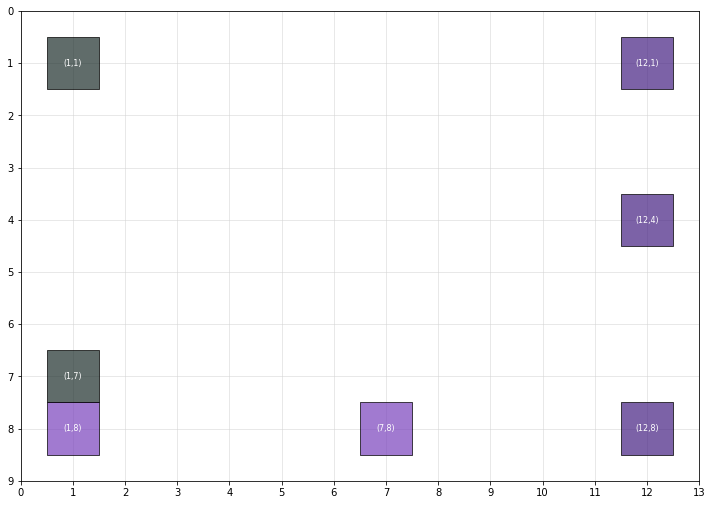

In [91]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

def plot_pcb_grid(grid):
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Set up grid lines
    ax.grid(True, which='both', color='lightgray', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Determine grid boundaries
    all_points = [p for points in grid.pads.values() for p in points]
    if not all_points:
        print("No pads found in grid!")
        return
    
    min_x = min(p.x for p in all_points)
    max_x = max(p.x for p in all_points)
    min_y = min(p.y for p in all_points)
    max_y = max(p.y for p in all_points)
    
    # Flip Y-axis (KiCad-style coordinates)
    ax.set_ylim(max_y + 1, min_y - 1)  # Reversed order
    
    ax.set_xlim(min_x - 1, max_x + 1)
    ax.set_xticks(range(min_x - 1, max_x + 2))
    ax.set_yticks(range(min_y - 1, max_y + 2))
    ax.set_aspect('equal')

    # Create rectangle patches (full grid cells)
    patches_list = []
    colors = []
    
    for net, points in grid.pads.items():
        color = tuple(c/255 for c in net.pad_c)  # Normalize RGB
        for point in points:
            # Create rectangle that fills the grid cell
            rect = patches.Rectangle(
                (point.x - 0.5, point.y - 0.5),  # Bottom-left corner
                1, 1,  # Width and height
                linewidth=1
            )
            patches_list.append(rect)
            colors.append(color)

    # Add all patches at once
    collection = PatchCollection(
        patches_list,
        facecolor=colors,
        edgecolor='black',
        alpha=0.7  # Slightly transparent
    )
    ax.add_collection(collection)

    # Add coordinate labels
    for net, points in grid.pads.items():
        for point in points:
            ax.text(
                point.x, point.y,
                f"({point.x},{point.y})",
                ha='center', va='center',
                fontsize=8, color='white'
            )

    # Create legend
    

    plt.tight_layout()
    plt.show()

# Usage
plot_pcb_grid(GRID)
    
